In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy
from matplotlib.pyplot import cm
from astropy import constants as const
from astropy import units as u
import numpy.ma as ma
import scipy.integrate as integrate
from scipy import interpolate
import csv
from scipy.integrate import simps
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D

# Populate the inside of a sphere with random points

In spherical coordinates a sphere is described through three coordinates: a radial one and two angular ones. We will call the radial one r and the angular ones phi and theta respectively.

First I define the king profile without normalizing it. It has two parameters, core radius and tidal radius. I got the king profile from the carraro notes, maybe it is not good, then change it

In [2]:
def not_normalized_king_profile(r, rt=1, rc=0.8):
    a = (1+(r/rc)**2)**-0.5
    b = (1+(rt/rc)**2)**-0.5
    NN_profile = (a-b)**2
    return NN_profile

Plot it to check it looks alright

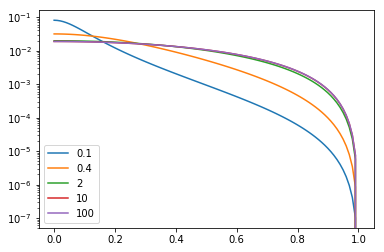

In [3]:
r_vector = np.linspace(0, 1, 100)
# Here I plotted it for several values of the parameter that we don't know, rc to see how it changed
plt.plot(r_vector,np.sum(not_normalized_king_profile(r_vector, rt=1, rc = 0.1))**-1*not_normalized_king_profile(r_vector, rt=1, rc = 0.1), label = '0.1')
plt.plot(r_vector,np.sum(not_normalized_king_profile(r_vector, rt=1, rc = 0.4))**-1*not_normalized_king_profile(r_vector, rt=1, rc = 0.4), label = '0.4')
plt.semilogy(r_vector,np.sum(not_normalized_king_profile(r_vector, rt=1, rc = 2))**-1*not_normalized_king_profile(r_vector, rt=1, rc = 2), label = '2')
plt.plot(r_vector,np.sum(not_normalized_king_profile(r_vector, rt=1, rc = 10))**-1*not_normalized_king_profile(r_vector, rt=1, rc = 10), label = '10')
plt.plot(r_vector,np.sum(not_normalized_king_profile(r_vector, rt=1, rc = 100))**-1*not_normalized_king_profile(r_vector, rt=1, rc = 100), label = '100')
plt.legend()
plt.show()

ignore these comented ones

In [4]:
# R = 1500
# rc = 0.4
# sterilization_dist = 8
# grid = 50

In [5]:
# plt.semilogx(r_vector,np.sum(not_normalized_king_profile(r_vector,R))**-1*np.cumsum(not_normalized_king_profile(r_vector,R)))

In [6]:
# def prob_stars_distances(R = 1500, rc=0.4, sterilization_dist = 8, grid = 50):
#     # Because this is a probability, it should be normalized to 1. 
#     # The entries here are the vector in which you want the probabilities computed r_vector
#     # rt the tidal radius: if i remember correctly this is just the cluster radius so 
#     # I am using it as the maximum possible radius. Default is 1, you can also put something physical
#     # but then you need to multiply rt and the R of the last function too. I suggest you always
#     # use it as 1 and then multiply the points in the end (so the x,y,z that are the outcome of 
#     # points_inside_sphere because it is the same
    
#     # So here, I define a vector of points between 0 and our maximum radius. These are like
#     # the u 
#     ratio = int(R/sterilization_dist)+1
#     rt = ratio*sterilization_dist
#     r_vector = np.linspace(0,rt,grid*ratio+1)
    
#     # Now I compute the profile with the function I defined before. It is not normalized.
#     not_normalized_profile = not_normalized_king_profile(r_vector, rt, rc)

#     #  we want discrete probabilities so instead of the integral we want the sum to be 1
#     norm_constant = (np.sum(not_normalized_profile))**-1
    

#     # Return the product which is the probabilities of each of the r_vector
#     # This is really just the same as not_normalized_king_profile but normalized
#     return norm_constant*not_normalized_king_profile(r_vector, rt, rc), r_vector

In [7]:
# ratio = int(R/sterilization_dist)+1
# rt = ratio*sterilization_dist
# r_vector = np.linspace(0,rt,50*ratio+1)

In [8]:
# r_vector[100]

In [9]:
# def fraction_in_this_sphere(k, sterilization_dist = 8, R=1500, rc = 0.4, grid = 50):
#     total_prob, r_vector =  prob_stars_distances(R, rc, sterilization_dist, grid)
#     r_sector = r_vector[k*grid:(k+1)*grid]
#     prob_sector = total_prob[k*grid:(k+1)*grid]
#     fraction = np.sum(prob_sector)
#     return fraction, r_sector, prob_sector

In [10]:
# fraction_in_this_sphere(0, sterilization_dist = 8, R=1500, rc = 100, grid = 50)

In [11]:
# fraction_in_this_sphere(1, sterilization_dist = 8, R=1500, rc = 0.4, grid = 50)

In [12]:
# # and you can check that it adds to 1:
# np.sum(prob_stars_distances(rt=1, rc=0.4))

In [13]:
# 1500/8

this one is the same as before

In [14]:
def prob_stars_distances(rt=1, rc=0.4):
    # Because this is a probability, it should be normalized to 1. 
    # The entries here are the vector in which you want the probabilities computed r_vector
    # rt the tidal radius: if i remember correctly this is just the cluster radius so 
    # I am using it as the maximum possible radius. Default is 1, you can also put something physical
    # but then you need to multiply rt and the R of the last function too. For simplicity,
    # use it as 1 and then multiply the points in the end (so the x,y,z that are the outcome of 
    # points_inside_sphere because it is the same
    
    # So here, I define a vector of points between 0 and our maximum radius. These are like
    # the u in that woman's email
    
    r_vector = np.linspace(0,rt,int(1e5))
    
    # Now I compute the profile with the function I defined before. It is not normalized.
    not_normalized_profile = not_normalized_king_profile(r_vector, rt, rc)

    #  we want discrete probabilities so instead of the integral we want the sum to be 1
    norm_constant = (np.sum(not_normalized_profile))**-1
    

    # Return the product which is the probabilities of each of the r_vector
    # This is really just the same as not_normalized_king_profile but normalized
    return norm_constant*not_normalized_king_profile(r_vector, rt, rc)

### Now to the sphere
The function we just defined will replace our old sampling of the radius

In [15]:
def points_inside_sphere(number, R=1):
    # R is the radius of the sphere. If you don't input anything it is automatically
    # set to 1
    
    # numbers is the number of points you want. This is where you control the
    # "density" of stars: by setting the number that corresponds to the 
    # density within the size R you chose
    
    # defining the variables and making them random. The function
    # np.random.uniform takes three inputs: the lower and upper bounday for 
    # the value of the variable and the the length of the array you want to return.
    # In this case, the length is just number, the number of stars you want
    phi =np.random.uniform(0,2*np.pi,number)
    mu = np.random.uniform(-1,1,number)
    theta = np.arccos(mu)
    ######## Here start the new things##############################
    rt = R # both the maximum radius are the same
    rc = 0.4 # I am using 0.4 RANDOMLY, check for the correct one for the bulge I guess

    
    ######### KINGS PROFILE ################
    
    pp=prob_stars_distances(rt, rc) 

    ########### Uniform #########################
    # comment and uncomment this one or the one above depending on what you want
 #   pp = np.sum(np.ones(int(1e5)))**-1*np.ones(int(1e5))
    
    
    
    
    r_vector = np.linspace(0,rt,int(1e5))
    
    # Here is the documentation of this function: https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.choice.html
    # Basically it is drawing random numbers (as many as you indicate in "numbers") so that they follow
    # the distribution in pp, so the king profile. The a=r_vector is to tell it which probability corresponds to 
    # which value and in which range we want our numbers
    
    samples = np.random.choice(a=r_vector, p=pp, size=number)
    ###############################################################################3
    ##### histogram to check if the distribution
    ##### is actually what is wanted
    for_checking = integrate.simps(not_normalized_king_profile(r_vector, rt, rc), r_vector)**-1
    for_checking1 = for_checking*not_normalized_king_profile(r_vector, rt, rc)
    plt.hist(samples, density=True, bins =100)
    plt.plot(r_vector, for_checking1)
    plt.xlabel('Normalized radius')
    ##############################################################################
    
    
    ########################### From here on I didn't change anything)
    # Here I normalize the radial coordinate to our desired radius
    r = R*samples**(1/3)
    
    # And this is just the points in a sphere in spherical coordinates
    x = r*np.sin(theta)*np.cos(phi)
    y = r*np.sin(theta)*np.sin(phi)
    z = r*np.cos(theta)
    
    # Here I am checking that all the points fullfill the equation for a 
    # sphere, x^2+y^2+z^2 =< R^2
    # If that is not true it would print "something went wrong"
    test = np.asarray([np.sqrt(x[i]**2+y[i]**2+z[i]**2) for i in range(number)])
    if np.where(test >R**2*1.00001)[0].size>0:
        print('Something went wrong')
    return x,y,z

So now let's test it! For plotting purposes (it is easier to see) I will also plot the surface of the sphere enclosing the points. 

First let's define a radius. I am using 1 for simplicity but could use whatever. In principle if you put here a "physical" quantity in, for example, kpc then it would all work the same and the x, y, z that the function returns would just be the position in a grid in kpc around the black hole. But that is the same as to multiply the resulting x, y, z by this number if you used R=1.

Basically the result you will have to work with are the arrays x, y, z that the function returns: those are the positions of your stars.

In [16]:
def radius_from_N(N,n=70):
    # Here i start with a number density of 70 pc-3 and using the number of stars I want (N) get the radius
    R = (3*N/(4*np.pi*n))**(1/3)
    return R

# Get the rescaled sterilization dist. The true ratio is 8/1500 but sometimes I use a smaller one to actually 
# get sterilizations
def sterilization_dist_from_N(N, n=70):
    R = (3*N/(4*np.pi*n))**(1/3)
    ratio = 50/1500
#     ratio = 8/150

    return ratio*R

In [17]:
# Play with these two to get the correct number of stars in the bulge
# cant really be set to more than 1e5 or jupyter will crash
# chose a number of points and then using the functions above you get the scaled system
points = int(1e5)
R = radius_from_N(points,70)
sterilization_distance = sterilization_dist_from_N(points, n=70)

# this should print 70 and then twice the same number
print(points/(4*np.pi*R**3/3))
print(70*(4*np.pi*sterilization_distance**3/3)/points)
print((8/1500)**3)

70.00000000000001
3.7037037037037016e-05
1.517037037037037e-07


In [18]:
total_vol = 4*np.pi*R**3/3
ster_vol = 4*np.pi*sterilization_distance**3/3
print(ster_vol/total_vol)
# this number should be the same as the two above

3.703703703703703e-05


And now the sphere surface for plotting it

In [19]:
phi_plot, theta_plot = np.mgrid[0.0:np.pi:100j, 0.0:2*np.pi:100j]
x_plot = R*np.sin(phi_plot)*np.cos(theta_plot)
y_plot = R*np.sin(phi_plot)*np.sin(theta_plot)
z_plot = R*np.cos(phi_plot) 

To put points inside the sphere we just use the function we created:

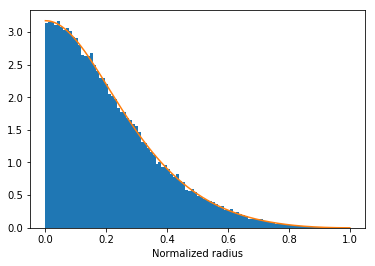

In [20]:
x, y, z = points_inside_sphere(points,R=1)
# Check that the curve and histogram match
x = R*x
y = R*y
z = R*z
# note that if you choose the uniform prob it will not follow the orange curve

uncomment this one to plot. don't if you have too many points or it will just take a lot of time

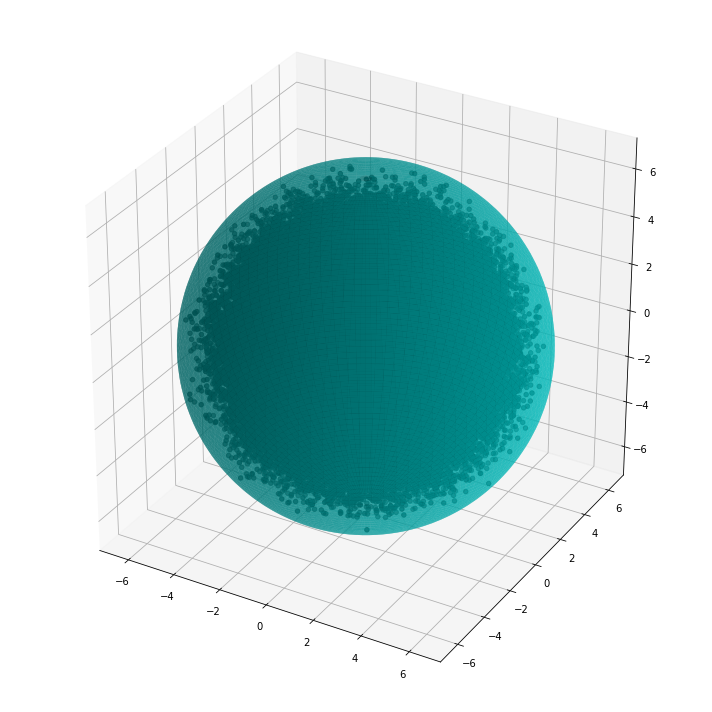

In [21]:
 fig = plt.figure(figsize=(10,10))
 ax = fig.add_subplot(111, projection='3d')

 ax.plot_surface(
     x_plot, y_plot, z_plot,  rstride=1, cstride=1, color='c', alpha=0.6, linewidth=0)

 ax.scatter(x,y,z,color="k",s=20)

 ax.set_xlim([-R,R])
 ax.set_ylim([-R,R])
 ax.set_zlim([-R,R])
 ax.set_aspect("equal")
 plt.tight_layout()
 plt.show()

In [22]:
class exploding_stars:
    
    def __init__(self, x, y, z, M, exploded, sterilized):
        """The instance of the class will be a star with position (x,y,z) and mass M in solar masses.

        Parameters:
        -----------
        x : float
            position in pc
        y : float
            position in pc
        z: float
            position in pc
        M : float
            mass of the star

        """
        self.x = x
        self.y = y
        self.z = z 
        self.M = M
        self.exploded = exploded
        self.sterilized = sterilized

        self.r = np.sqrt(self.x**2 + self.y**2 + self.z**2)

The IMF is not ok but that doesn't matter right now because we always have 1% explosions due to the binaries
I implemented the power law indexes but need to fix the normalizations so they connect. It is supposed to be a piecewise powerlaw but now it just looks wonky. I also digitized one (kroupa) which can be used instead

In [23]:
M_vector = np.logspace(-2,2,100)*u.M_sun
def IMF_Kroupa(M_vector):
        alpha = np.zeros(len(M_vector))
        result1 = np.zeros(len(M_vector))
        for i in np.arange(len(M_vector)):
            if M_vector[i] < 0.08*u.M_sun:
                alpha[i] = -0.3
            elif M_vector[i] < 0.5*u.M_sun:
                alpha[i] = -1.3
            else:
                alpha[i] = -2.3
            result1[i] = (M_vector[i]/(1*u.M_sun))**alpha[i]
        norm = np.sum(result1)**-1
        result = norm*result1
        return result

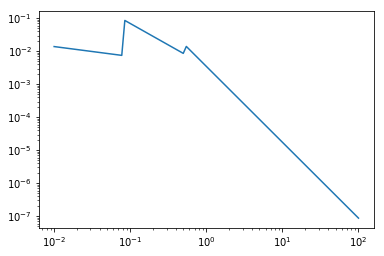

In [24]:
plt.loglog(M_vector, IMF_Kroupa(M_vector))
# Need to normalize - it should take a min to fix, i just haven't had the time 

In [25]:
# from the digitized file
kroupa = np.loadtxt('kroupa.csv', delimiter = ',')

this is the same as before

In [26]:
stars = []
pp = IMF_Kroupa(M_vector)
# I am not sure if sample_mass will be a vector or a number. This is for a vector
sample_mass = np.random.choice(a=M_vector, p=pp, size=points)
for i in np.arange(len(x)):
    M = sample_mass[i]
#     M = 8 #remove this once you have the IMF
    stars.append(exploding_stars(x[i], y[i], z[i], M, False, False))

In [27]:
SN_mass_threshold = 8
n = 0
for i in stars:
    if i.M > SN_mass_threshold:
        i.exploded = True
    else:
        if divmod(n,100)[1]==0:
            i.exploded = True
            n = n+1
        else:
            n = n+1
        

In [28]:
# sterilization_distance = 8
minim = []
#8
for i in stars:
    prueba = []
    if i.exploded == True:
        x_SN = i.x
        y_SN = i.y
        z_SN = i.z
        for j in stars:
            x_star = j.x
            y_star = j.y
            z_star = j.z
            dist_to_SN = np.sqrt((x_SN-x_star)**2+(y_SN-y_star)**2+(z_SN-z_star)**2)
            prueba.append(dist_to_SN)
            if dist_to_SN < sterilization_distance:
                j.sterilized = True
        minim.append(np.min(np.asarray(prueba)[np.nonzero(prueba)]))


In [29]:
1/(70**(1/3))

0.2426427503202587

the next two numbers are the sterilization distance and the mean minumum distance between stars. to get sterilizations, the min dist should be smaller than the steri. dist. but it isnt :((((

In [30]:
sterilization_distance

0.23288947516919992

In [31]:
np.mean(np.asarray(minim))

0.11430151260890271

In [32]:
number = 0 
# a = 187.5
a = 20
for i in stars:
    if i.r < a*sterilization_distance:
        number = number + 1
# here i compute how many stars there are in concentric spheres of radius a*sterilizations distance.
# the first number is the number density: should be 70 when a is the maximum, 187.5
print(number/((4*np.pi*(a*sterilization_distance)**3)/3))
# the second is the actual number
print(number)

174.49661250000003
73861


these two fractions should remain the same when you change the number of points N. for some reason, the first one doesnt

In [33]:
np.mean(np.asarray(minim))/R

0.016359908138951586

In [34]:
sterilization_distance/R

0.03333333333333333

In [35]:
number_of_sterilized = 0
number_of_exploded = 0

for i in stars:
    if i.sterilized:
        number_of_sterilized = number_of_sterilized+1
    if i.exploded:
        number_of_exploded= number_of_exploded+1

In [36]:
number_of_sterilized

8391

In [37]:
number_of_exploded

1018

In [38]:
number_of_sterilized-number_of_exploded

7373

In [39]:
number_of_sterilized/points

0.08391

In [40]:
number_of_exploded/points

0.01018

uncomment the plot if you have not a lot of points

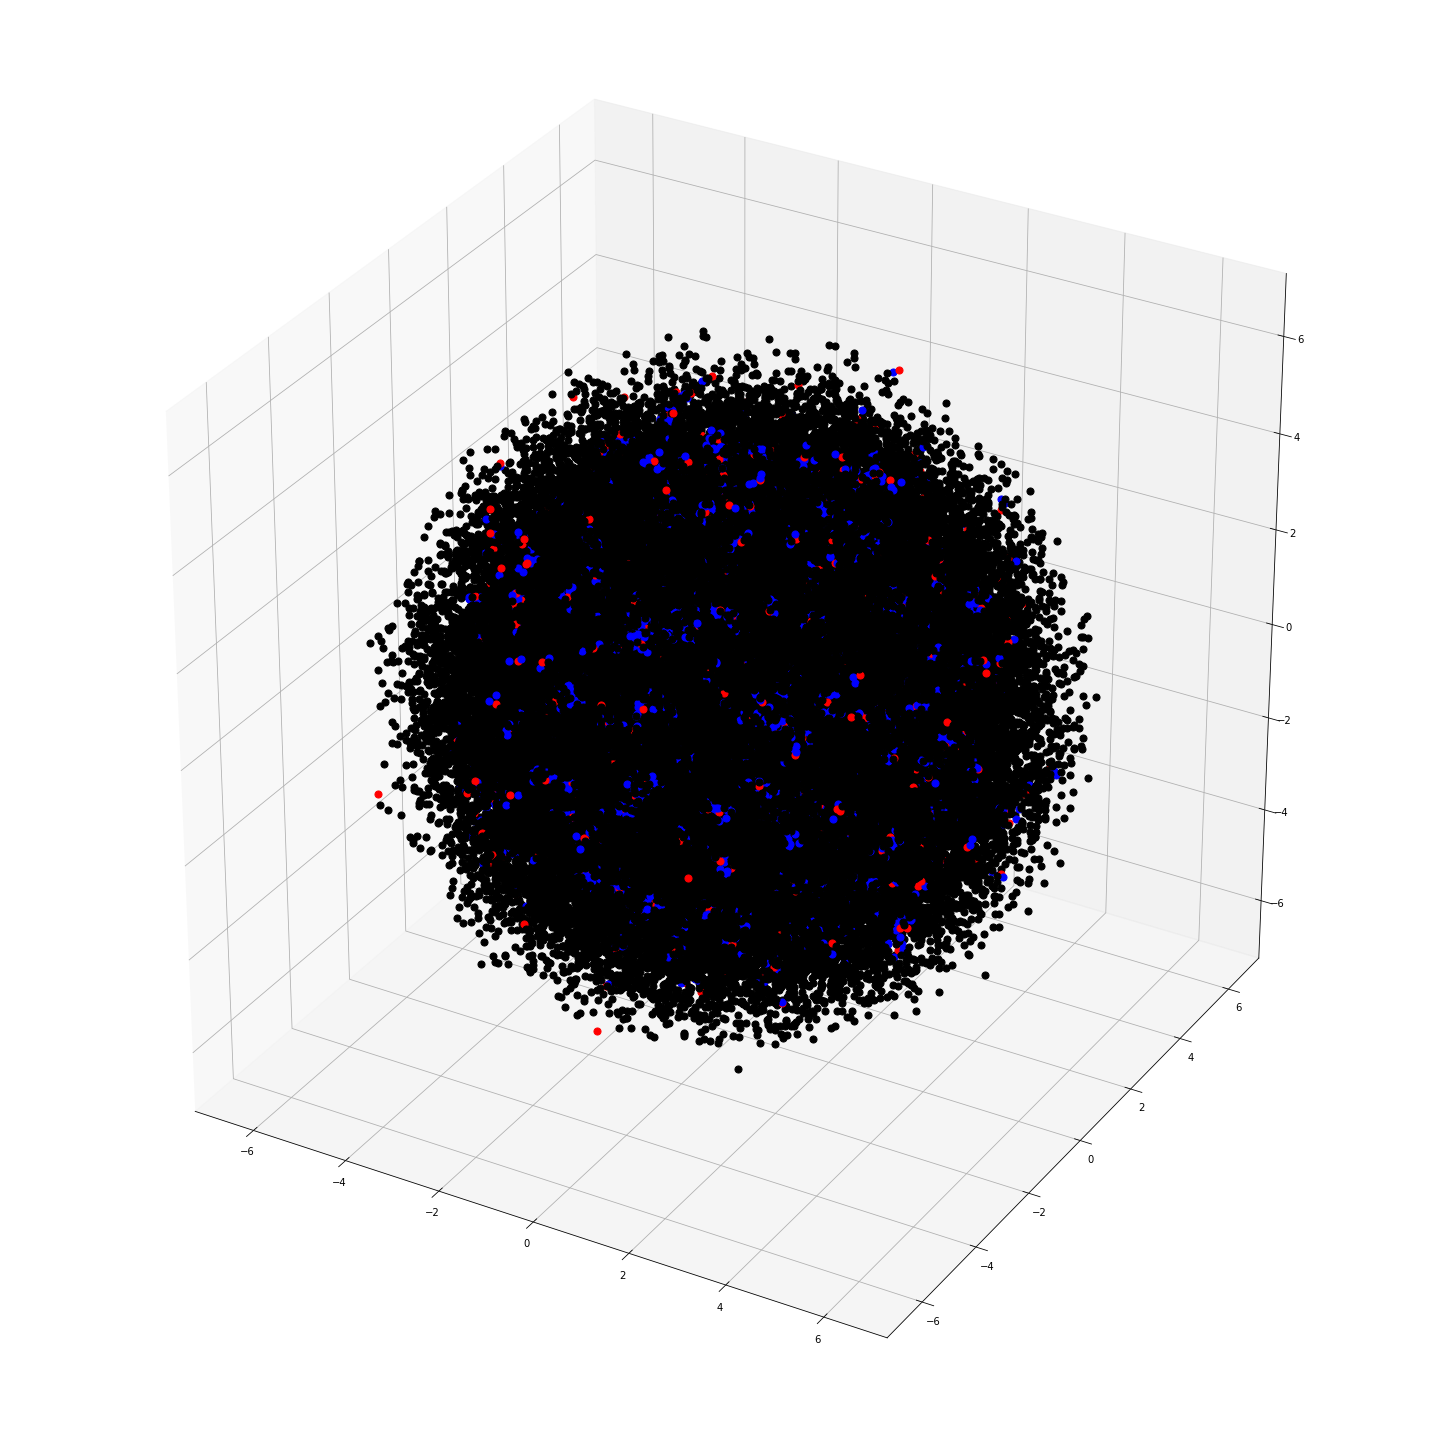

In [41]:
 fig = plt.figure(figsize=(20,20))
 ax = fig.add_subplot(111, projection='3d')

#ax.plot_surface(
#      x_plot, y_plot, z_plot,  rstride=1, cstride=1, color='c', alpha=0.2, linewidth=0)
 for i in stars:
     if i.exploded == True:
         color = 'red'
     elif (i.exploded == False) and (i.sterilized == True):
         color = 'blue'
     else:
         color = 'k'
     ax.scatter(i.x,i.y,i.z,color=color, s=50)

  ###NEED TO ACCT FOR AGN. bulge radius: 1993pc. AGN sterilization: out to 200pc. thus, 10% of all stars, all
  ### within innermost part of sphere, are sterilized due to AGN
    
    
 ax.set_xlim([-R,R])
 ax.set_ylim([-R,R])
 ax.set_zlim([-R,R])
 ax.set_aspect("equal")
 plt.tight_layout()
 plt.show()

In [42]:
bins = 10
r_histogram = np.linspace(0,R,bins)
histogram = np.zeros(bins)

In [43]:
for i in stars:
    if i.sterilized:
        for j in np.arange(len(r_histogram)):
            if i.r < r_histogram[j]:
                histogram[j] = histogram[j] +1
                break

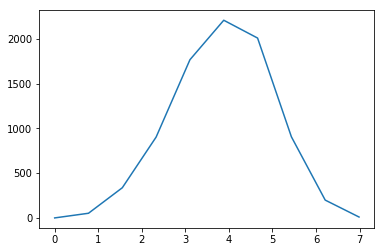

In [44]:
plt.plot(r_histogram, histogram)

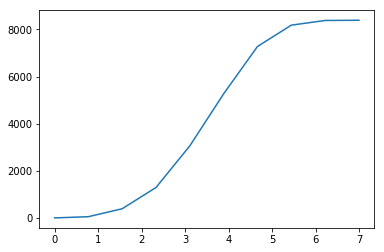

In [45]:
plt.plot(r_histogram, np.cumsum(histogram))

runs = 100

for k in np.arange(runs):
    HERE IT ALL WITHOUT PLOTS

    np.save('histogram' + str(k), histogram)
    
    #and then you load it 
    np.load('histogramX.npy')

<BarContainer object of 3 artists>

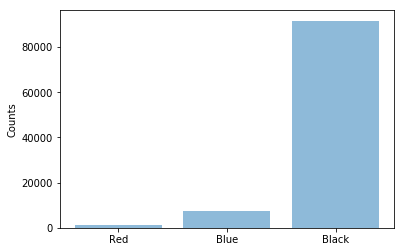

In [46]:
import matplotlib.pyplot as plt
red_count = 0
blue_count = 0
black_count = 0
objects = ('Red', 'Blue', 'Black')

for i in stars:
    if i.exploded == True:
        color = 'red'
        red_count += 1
    elif (i.exploded == False) and (i.sterilized == True):
        color = 'blue'
        blue_count += 1
    else:
        color = 'k'
        black_count += 1

y_pos = np.arange(len(objects))
performance = [red_count, blue_count, black_count]
plt.xticks(y_pos, objects)
plt.ylabel('Counts')
plt.bar(y_pos, performance, align='center', alpha=0.5)